<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/pulsar_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 8th June, 2023

## Basics

In [11]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Call libraries

In [12]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

In [13]:
# 1.05
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### Read data

In [14]:
# 2.0 Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/pulsar_data_train.csv")
data.head(3)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


In [15]:
# 2.0.1

data.shape      # (12528, 8)
print("\n===\n")
data.dtypes

(12528, 9)


===



 Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                     float64
dtype: object

In [16]:
# 2.1 Check nulls
#     We will need to impute it:

data.isnull().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

In [17]:
# 2.2 Rename columns with spaces:

data = data.rename(columns = { " Mean of the integrated profile" : "Mean_integrated_profile",
                               " Standard deviation of the integrated profile" : "Std_dev_integrated_profile",
                               " Excess kurtosis of the integrated profile" : "Excesskurtosis_integrated_profile",
                               " Skewness of the integrated profile" : "Skewness_integrated_profile",
                               " Mean of the DM-SNR curve" : "Mean_DM_SNR_curve",
                               " Standard deviation of the DM-SNR curve" : "Std_dev_DM_SNR_curve",
                               " Excess kurtosis of the DM-SNR curve" : "ExcessKurtosis_DM_SNR_curve",
                               " Skewness of the DM-SNR curve" : "SkewnessDM_SNR_curve"
                             }
                   
                   )    

# 2.2.1
data.head(3)


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


### Histogram and boxplots of features

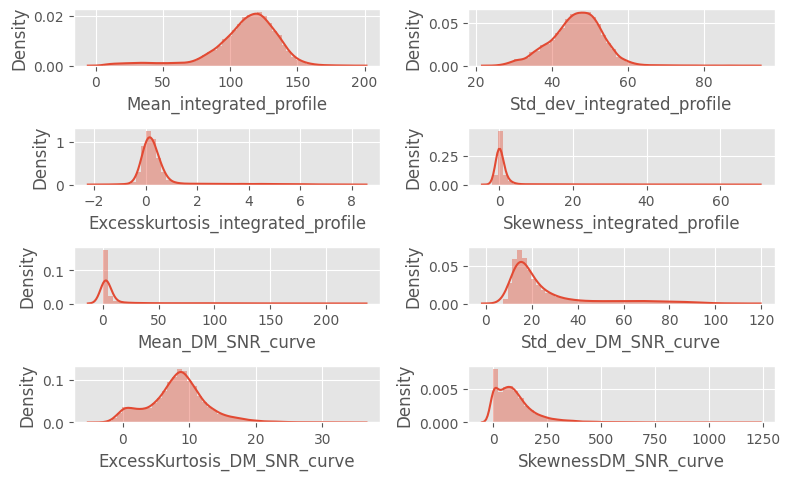

In [18]:
# 2.3 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.distplot(data[i],ax=ax);
    plt.tight_layout();

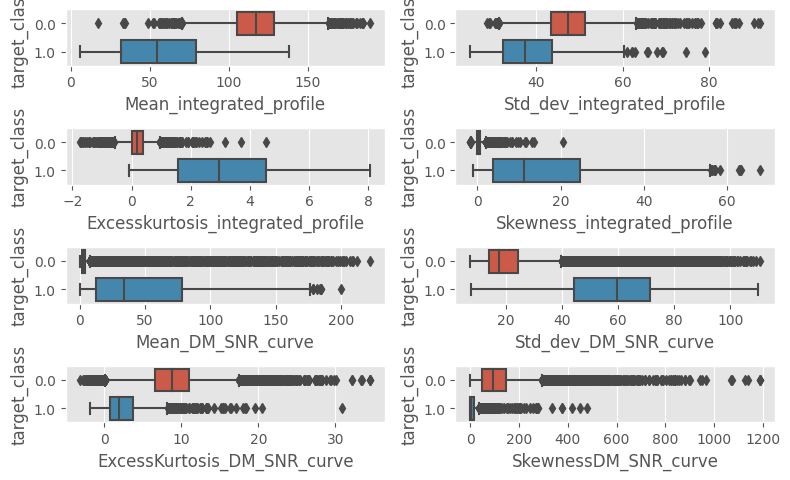

In [19]:
# 2.4 Lets look at how features are related to target:

df = data.copy()
df['target_class'] = df['target_class'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target_class')
    plt.tight_layout();

del(df)

In [20]:
# 2.5 Pop out target and check
#       proportions of classes

y = data.pop("target_class")

# 2.0.2 Imbalanced data:
y.value_counts(normalize = True)   

0.0    0.907966
1.0    0.092034
Name: target_class, dtype: float64

## Transform numeric data to categorical

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand. 

In [21]:
# 3.0 How many unique values exist per column?
#     So 30 bins per column should not be excessive:

for i in data.columns[:-1]:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in Mean_integrated_profile:  	 7192
No of unique values in Std_dev_integrated_profile:  	 12510
No of unique values in Excesskurtosis_integrated_profile:  	 10793
No of unique values in Skewness_integrated_profile:  	 12528
No of unique values in Mean_DM_SNR_curve:  	 7224
No of unique values in Std_dev_DM_SNR_curve:  	 11348
No of unique values in ExcessKurtosis_DM_SNR_curve:  	 12526


In [22]:
# 3.0.1 Discretise all features of data. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                                 y,
                                                                                 bins = 30,
                                                                                 test_size = 0.1,
                                                                                 genColName = False  # Keep orig col names
                                                                                )

In [23]:
# 3.0.2 Check  original data:

orig_train.shape   # (11276, 9)
orig_train.head(3)
orig_test.head(3)


(11276, 9)

,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
2167,78.460938,37.632246,0.761066,2.516426,2.241639,17.166000,8.768599,85.693532,0.0
8886,137.500000,37.165172,NaN,1.245371,3.239130,25.127128,8.179860,68.019792,0.0
8243,104.585938,48.763704,1.217617,1.745403,43.056856,68.276894,1.392848,0.564216,0.0


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
4041,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
10147,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
11684,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


In [24]:
# 3.0.3 Check discretised features
#       train/test in binned data and original 
#       split data have the same row-indicies:

train_binned.shape     # (11276, 9)
train_binned.head(3)
test_binned.head(3)


(11276, 9)

,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
2167,412,86,128,162,201,243,2810,323,0.0
8886,422,86,NaN,162,201,246,2810,322,0.0
8243,417,811,1210,162,206,2418,284,321,0.0


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
4041,419,811,127,161,201,244,289,322,0.0
10147,412,86,128,163,201,243,2810,323,0.0
11684,421,813,126,161,201,245,2810,322,0.0


In [25]:
# 3.0.4 No of unique values in train_binned
#       Less than 30 (no of bins) in a feature 
#       would cause NaN values in test_binned 
#       when transformed to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature Mean_integrated_profile are 	 30
No of unique values in feature Std_dev_integrated_profile are 	 28
No of unique values in feature Excesskurtosis_integrated_profile are 	 30
No of unique values in feature Skewness_integrated_profile are 	 29
No of unique values in feature Mean_DM_SNR_curve are 	 30
No of unique values in feature Std_dev_DM_SNR_curve are 	 30
No of unique values in feature ExcessKurtosis_DM_SNR_curve are 	 30
No of unique values in feature SkewnessDM_SNR_curve are 	 28


### Impute data: Learn using train data:

In [26]:
# 4.1 Impute original data
#     strategy: 'median'

si = SimpleImputer(strategy = 'median')
orig_train[:] = si.fit_transform(orig_train)
orig_test[:] = si.transform(orig_test)

In [27]:
# 4.2 Impute binned data:
#     strategy: 'most_frequent'

si = SimpleImputer(strategy = 'most_frequent')
train_binned[:] = si.fit_transform(train_binned)
test_binned[:] = si.transform(test_binned)

In [28]:
# 4.3 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [29]:
## 5.0 Developing models
#      Decide our cat_cols

cat_cols = list(train_binned.columns)  # All columns
len(cat_cols)  # 8


# Keep interacting columns, same
# as cat columns:
interactingCatCols = cat_cols  # alternative: []

8

In [30]:
# Instantiate CustomTransformer class:
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,0,0],  # This is better than all 1s
                       )

# Fit it:
ct.fit(train_binned, cat_cols, interactingCatCols) 


Record set no is 1  
Set of records is:  [('Mean_integrated_profile', 'Std_dev_integrated_profile', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Excesskurtosis_integrated_profile', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Skewness_integrated_profile', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Mean_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Std_dev_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'ExcessKurtosis_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'SkewnessDM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'ExcessKurtosis_DM_SNR_curve_p_SkewnessDM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Mean_integrated_profile_p_Excesskurtosis_integrated_profile', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Excesskurtosis_integrated_profile_p_Mean_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Mean_DM

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 0, 0],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

In [31]:
# 6.0 Transform both 'test_binned' and 'train_binned' data:
#     Takes time....

test_trans = ct.transform(test_binned)

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1120
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 8.784032 MB
Mem usage after dtype transformation is: 4.437088 MB


'Transformed test data shape: (1252, 876)'

In [32]:
# 6.0.1 Transform train_binned now:
#       Takes time....

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1120
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 79.112416 MB
Mem usage after dtype transformation is: 39.962144 MB


'Transformed train data shape: (11276, 876)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [33]:
# 6.1 Observe data now:
#     It also has original binned cols (10):

train_trans.head()
test_trans.head()

,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,deg_Mean_integrated_profile_ck_Std_dev_integrated_profile,eig_Mean_integrated_profile_ck_Std_dev_integrated_profile,...,clu_SkewnessDM_SNR_curve_ck_Excesskurtosis_integrated_profile_p_Skewness_integrated_profile,eig_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_SkewnessDM_SNR_curve,deg_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,eig_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,pr_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,clu_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,deg_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,eig_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,pr_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,clu_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve
0,412,86,128,162,201,243,2810,323,1.0,0.185046,...,0.91453,-0.148818,0.185185,0.147612,0.032445,0.800000,0.703704,0.175629,0.033315,0.941520
1,422,86,126,162,201,246,2810,322,1.0,0.185046,...,0.91453,-0.125957,0.111111,0.101621,0.021618,1.000000,0.703704,0.175629,0.033315,0.941520
2,417,811,1210,162,206,2418,284,321,1.0,0.185046,...,0.91453,-0.155371,0.777778,0.481320,0.120603,0.233333,1.000000,0.226934,0.046330,0.740741
3,421,812,126,161,201,245,289,322,1.0,0.185046,...,0.91453,-0.125957,0.111111,0.101621,0.021618,1.000000,0.703704,0.175629,0.033315,0.941520
4,417,86,127,162,201,242,2811,324,1.0,0.185046,...,0.91453,0.071066,0.222222,0.173638,0.037604,0.733333,0.703704,0.175629,0.033315,0.941520


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,deg_Mean_integrated_profile_ck_Std_dev_integrated_profile,eig_Mean_integrated_profile_ck_Std_dev_integrated_profile,...,clu_SkewnessDM_SNR_curve_ck_Excesskurtosis_integrated_profile_p_Skewness_integrated_profile,eig_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_SkewnessDM_SNR_curve,deg_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,eig_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,pr_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,clu_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,deg_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,eig_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,pr_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,clu_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve
0,419,811,127,161,201,244,289,322,1.0,0.185046,...,0.91453,-0.125957,0.111111,0.101621,0.021618,1.000000,0.703704,0.175629,0.033315,0.941520
1,412,86,128,163,201,243,2810,323,1.0,0.185046,...,0.91453,-0.148818,0.185185,0.147612,0.032445,0.800000,0.703704,0.175629,0.033315,0.941520
2,421,813,126,161,201,245,2810,322,1.0,0.185046,...,0.91453,-0.125957,0.111111,0.101621,0.021618,1.000000,0.703704,0.175629,0.033315,0.941520
3,425,811,125,161,203,243,285,321,1.0,0.185046,...,0.91453,-0.155371,0.777778,0.481320,0.120603,0.233333,1.000000,0.226934,0.046330,0.740741
4,413,86,128,163,201,244,2810,322,1.0,0.185046,...,0.91453,-0.125957,0.111111,0.101621,0.021618,1.000000,0.703704,0.175629,0.033315,0.941520


In [34]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCAs with original data and with transformed data:
We perform PCA of transformed data with all features. We latter perform PCA again but only with important features.

In [35]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(11276, 2)

In [36]:
# 7.1 PCA with transformed train data.
#     Drop all cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape  # (18000, 2)

(11276, 2)

In [37]:
# 7.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

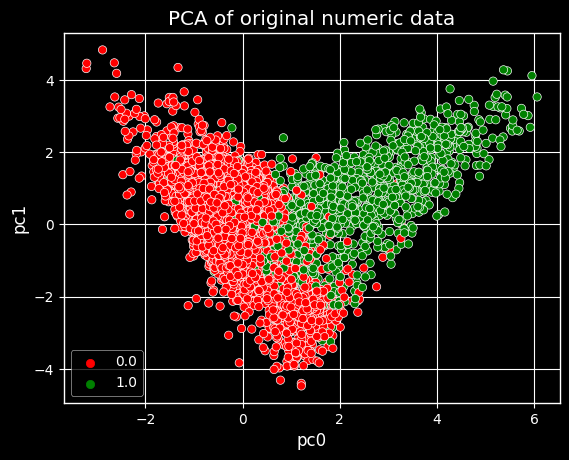

In [38]:
# 8.1 PCA plot from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA of original numeric data');


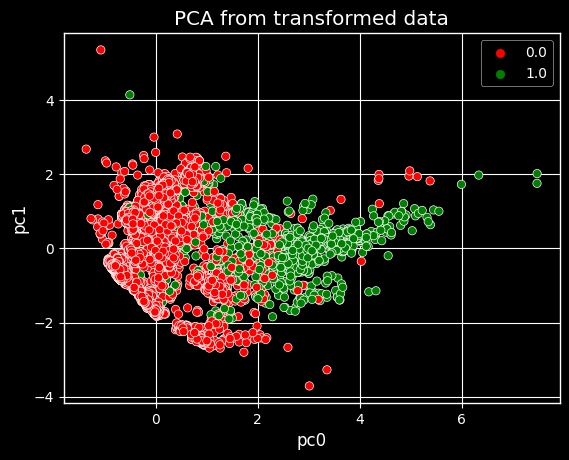

In [39]:
# 8.2 PCA plot from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;

##xgboost modeling of original features and of transformed features


In [42]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 700,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               random_state = None,
                              )

# 9.0.1
tr_X =   orig_train
test_X = orig_test
ytr = ytr 
yte = yte 

# 9.0.2
model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 100,   
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)], 
               eval_metric = ['auc']        
              )



[11:40:12] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[11:40:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.95023	validation_1-auc:0.94589
[11:40:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.97006	validation_1-auc:0.96251
[11:40:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.96945	validation_1-auc:0.96002
[11:40:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.96979	validation_1-auc:0.95983
[11:40:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.96904	validation_1-auc:0.95925
[11:40:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [43]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9752221339305064'

'Best iteration from orig train/test data: 216'

In [44]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 600,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.8,        
                           random_state = None,
                           )

# 9.21
tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr 
yte = yte 

# 9.22
model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 100, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[11:40:32] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[11:40:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation_0-auc:0.94862	validation_1-auc:0.94580
[11:40:35] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.96592	validation_1-auc:0.94538
[11:40:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.97378	validation_1-auc:0.96099
[11:40:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation_0-auc:0.97349	validation_1-auc:0.96012
[11:40:40] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.97519	validation_1-auc:0.96088
[11:40:40] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve plots

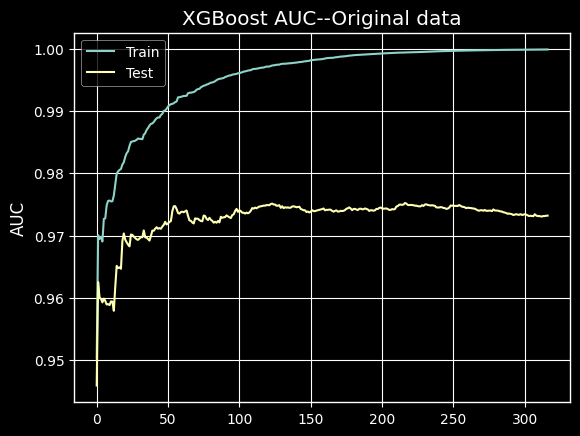

In [45]:
# 9.3 Learning curve of modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Original data');
plt.show();

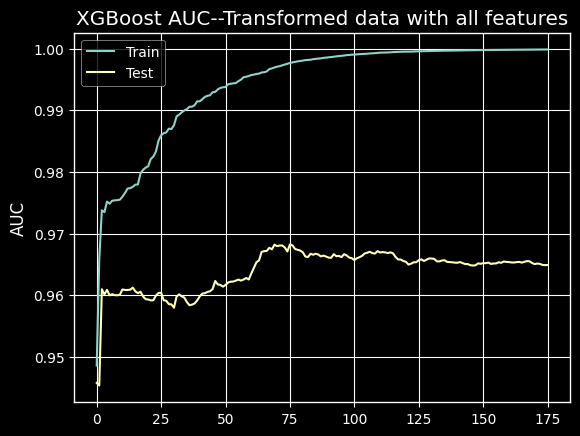

In [46]:
# 9.4 Learning curve of model with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data with all features');
plt.show();

In [47]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.9682631414192492'

'Best iteration from transformed train/test data: 75'

## Feature importance of transformed features:
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::  
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>  

In [48]:
# 10.0 Get feature importance:

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
clu_Skewness_integrated_profile_ck_Std_dev_integrated_profile_p_Mean_DM_SNR_curve,0.322119
eig_Skewness_integrated_profile_ck_Mean_integrated_profile_p_Std_dev_integrated_profile,0.249915
eig_Excesskurtosis_integrated_profile_ck_Excesskurtosis_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,0.022363
clu_ExcessKurtosis_DM_SNR_curve_ck_Mean_DM_SNR_curve,0.009621
pr_Excesskurtosis_integrated_profile_ck_Mean_DM_SNR_curve_p_Std_dev_DM_SNR_curve,0.007363




== Column-list whose feat impt >0 =======



['clu_Skewness_integrated_profile_ck_Std_dev_integrated_profile_p_Mean_DM_SNR_curve',
 'eig_Skewness_integrated_profile_ck_Mean_integrated_profile_p_Std_dev_integrated_profile',
 'eig_Excesskurtosis_integrated_profile_ck_Excesskurtosis_integrated_profile_p_ExcessKurtosis_DM_SNR_curve',
 'clu_ExcessKurtosis_DM_SNR_curve_ck_Mean_DM_SNR_curve',
 'pr_Excesskurtosis_integrated_profile_ck_Mean_DM_SNR_curve_p_Std_dev_DM_SNR_curve']



===Column-list whose feat impt is 0 =======



['eig_Std_dev_integrated_profile_ck_SkewnessDM_SNR_curve',
 'clu_Mean_integrated_profile_ck_Mean_DM_SNR_curve_p_ExcessKurtosis_DM_SNR_curve',
 'eig_Mean_integrated_profile_ck_Mean_DM_SNR_curve_p_SkewnessDM_SNR_curve',
 'deg_Mean_integrated_profile_ck_Mean_DM_SNR_curve_p_SkewnessDM_SNR_curve',
 'pr_SkewnessDM_SNR_curve_ck_Mean_DM_SNR_curve_p_ExcessKurtosis_DM_SNR_curve']

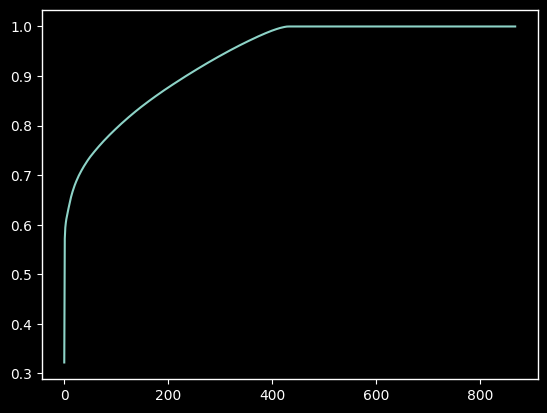

In [49]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

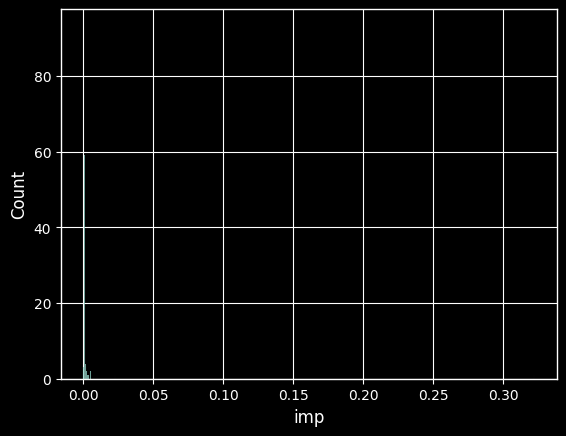

In [50]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt much below 0.01

sns.histplot(fe['imp'][fe_1]);

### XGBoost modeling with impt features

In [69]:
# 11.0 Modeling of transformed train/test data with impt features:

model_trans = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.8,        
                           random_state = None,
                           )

# 11.0.1
tr_X =   train_trans[fe_1[:30]]
test_X = test_trans[fe_1[:30]]
ytr = ytr 
yte = yte 


# 11.0.2
model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 50, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[11:47:59] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[11:47:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.94540	validation_1-auc:0.94192
[11:47:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.96844	validation_1-auc:0.96158
[11:47:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation_0-auc:0.97104	validation_1-auc:0.96058
[11:47:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation_0-auc:0.97095	validation_1-auc:0.95922
[11:47:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=12
[4]	validation_0-auc:0.97292	validation_1-auc:0.96114
[11:47:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes,

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

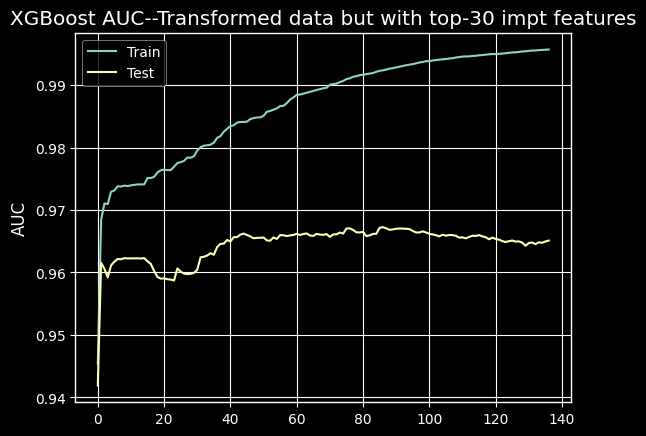

In [79]:
# 11.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data but with top-30 impt features');
plt.show();

## PCAs with original data and impt features of transformed data:
While performing PCA, we only use impt features

In [71]:
# 12.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(11276, 2)

In [72]:
# 12.1 PCA with transformed train data.
#      We keep just the impt features

trans_pca = train_trans[fe_1[:30]] #.iloc[:,len(cat_cols):]  
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(11276, 2)

In [73]:
# 12.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

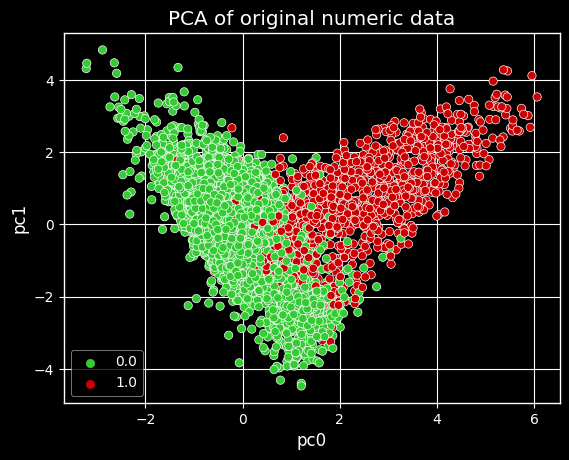

In [74]:
# 12.3 PCA plot from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


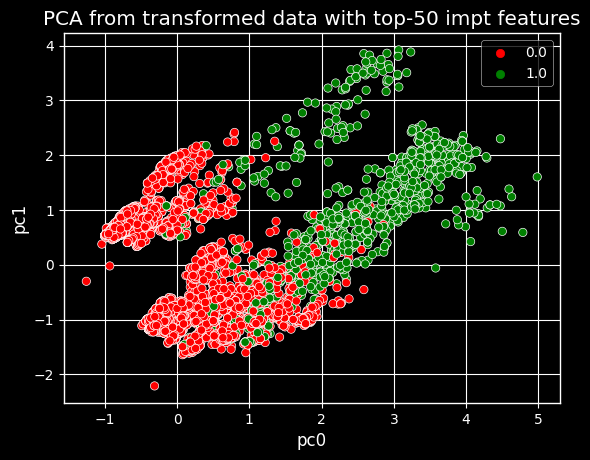

In [75]:
# 12.4 PCA plot from transformed data but with impt features:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data with top-50 impt features') ;


## Correlation with orig columns
Correlation of extracted features with original features

In [76]:
# 13.0 Take top five imp features:

tt = train_trans[fe_1[:10]].copy()
tt.shape  # (9000,341)

(11276, 10)

In [77]:
# 13.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

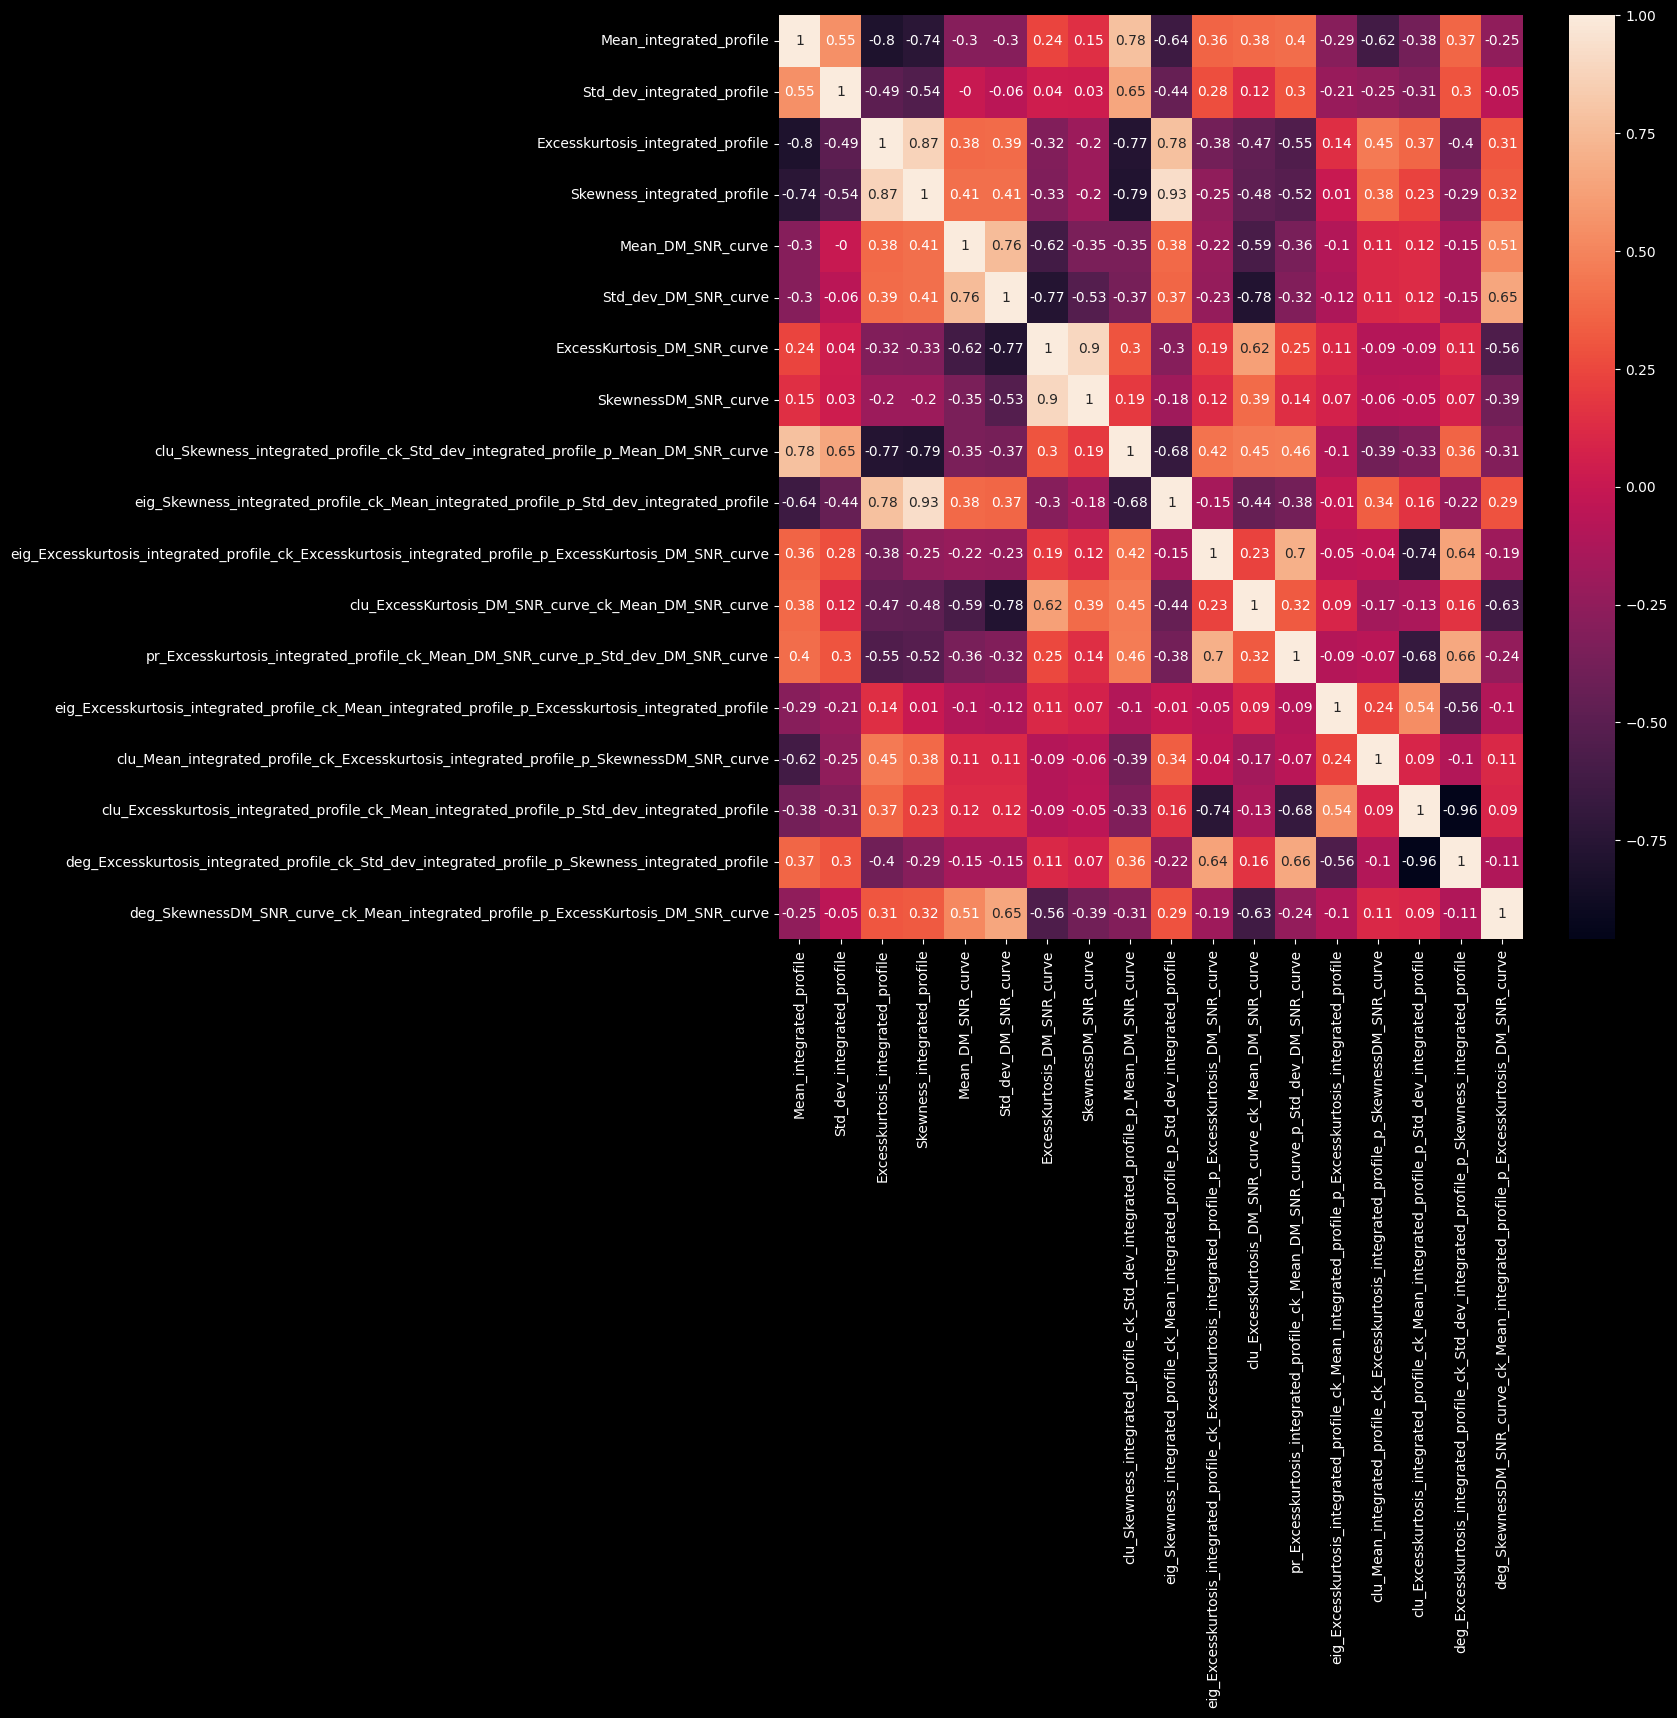

In [78]:
# 13.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

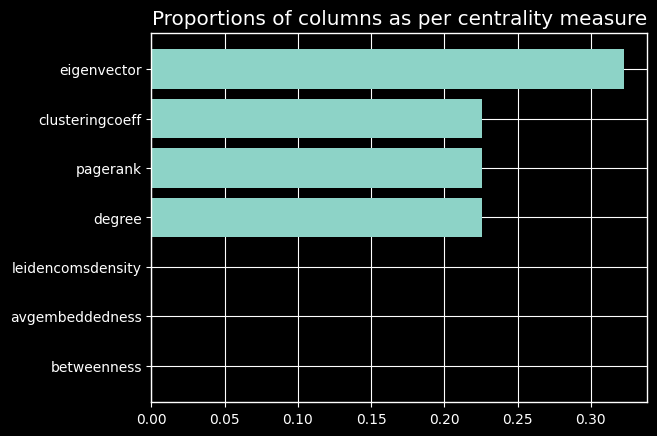

In [ ]:
# 14.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 14.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 48'

'Columns whose impt is 0: 2'

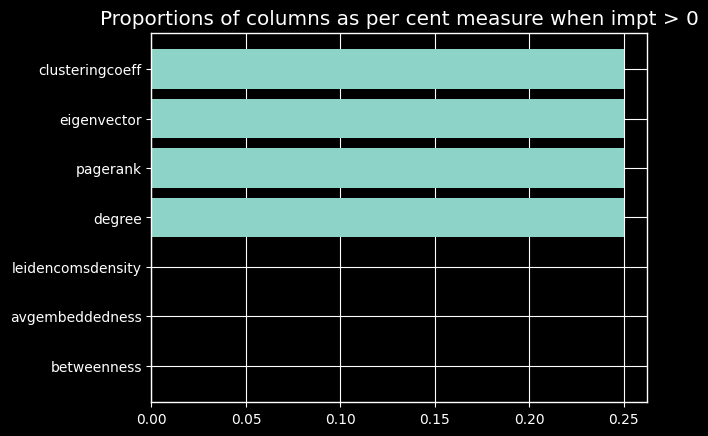

In [ ]:
# 14.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 15.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [ ]:
# 15.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 15.2 Score of all impt columns:
score[:5]

eig_Mean_integrated_profile_ck_Std_dev_integrated_profile                                 0.500326
deg_Mean_integrated_profile_ck_Std_dev_integrated_profile                                 0.088257
clu_Mean_integrated_profile_ck_Skewness_integrated_profile                                0.031410
pr_Mean_integrated_profile_ck_Std_dev_integrated_profile                                  0.030152
pr_Mean_integrated_profile_ck_Excesskurtosis_integrated_profile_p_SkewnessDM_SNR_curve    0.017984
Name: imp, dtype: float32

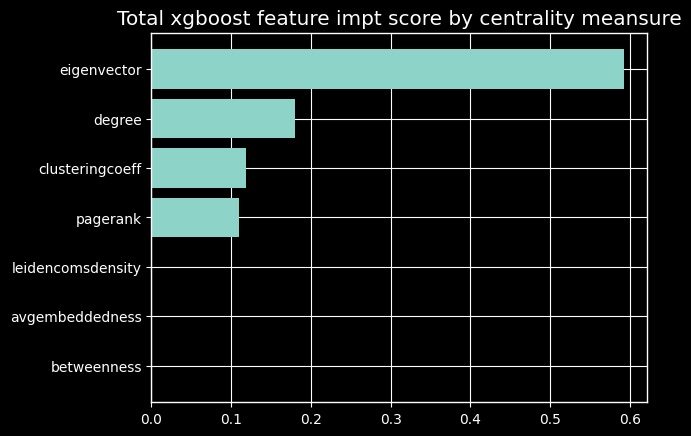

In [ ]:
# 15.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")